# Purpose

This notebook conducts an exploratory analysis to get a broad sense of how BGG user preferences trend as well as giving a better understanding of various statistics of our data set such as how many comments users tend to post and how ratings are distributed. Particularly, we will see that there are $7687447$ ratings spread across $250078$ users resulting in a matrix which is $\sim97\%$ sparse.

In [1]:
from boardgamegeek import BGGClient
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import re
from proxy_requests.proxy_requests import ProxyRequests
from retry import retry
import time
import os
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import random
import pickle

from pyspark import SparkContext
from lxml import etree

In [2]:
def local_path(path):
    
    return 'file://'+str(os.path.abspath(os.path.curdir))+'/'+path

sc = SparkContext('local[*]','temp')

#get only the files that will have stats
files = sc.wholeTextFiles(local_path('../DataAcquisition/Data/*/*_1.xml'))

In [3]:
def stats_aggregator(xml):
    # This function will be used by map to give the game id as key and a tuple [total,comments_count] 
    # where total is either 0 or if the xml is the first page of xml the total expected comment count
    # comments count is the count of comments on the page
    
    #get the game id form the directory name
    key = ((xml[0]).split('/')[-1]).split('_')[0]
    
    #soupify the xml
    soup = BeautifulSoup(xml[1])
    
    #see if it's the first page to get expected total comment count
    try:
    
        total = int(soup.comments['totalitems'])
        year = int(soup.yearpublished['value'])
        min_player_count = int(soup.minplayers['value'])
        max_player_count = int(soup.maxplayers['value'])
        complexity = float(soup.averageweight['value'])
        game_type = None
        exp_count=0

        for x in soup.find_all('link'):

            if x['type'] == 'boardgameexpansion':

                exp_count+=1
                
        for x in soup.find_all('rank'):

            if x['type'] == 'family':

                game_type=x['name']

        score = float(soup.average['value'])

        
        
        
    except:
        
        total = 0
        year = 0
        min_player_count = 0
        max_player_count = 0
        complexity = 0
        game_type=None
        exp_count=0
        score = 0
    
    
    return (key, [total, year, min_player_count, max_player_count, complexity, exp_count, game_type,score])

def user_rating_parser(xml):
    # This function will return an rdd with game_id as key and a tuple as value
    # where the tuple is [user,rating]
    
    #get game id as key
    key = ((xml[0]).split('/')[-1]).split('_')[0]
    
    soup = BeautifulSoup(xml[1])
    
    comments = soup.find_all('comment')
    
    # get rating and username for each comment and yield k,v pair
    for comment in comments:
        
        user = comment.get('username')
        
        rating = comment.get('rating')
        
        yield (key,[user,float(rating)])
        

def user_rating_pairs(xml):
    # This function will return an rdd with game_id as key and a tuple as value
    # where the tuple is [user,rating]
    
    
    soup = BeautifulSoup(xml[1])
    
    comments = soup.find_all('comment')
    
    # get rating and username for each comment and yield k,v pair
    for comment in comments:
        
        user = comment.get('username')
        
        rating = comment.get('rating')
        
        yield (user,float(rating))
        

def user_rating_counter(xml):
    # This function will return an rdd with game_id as key and a tuple as value
    # where the tuple is [user,rating]
    
    soup = BeautifulSoup(xml[1])
    
    comments = soup.find_all('comment')
    
    # get rating and username for each comment and yield k,v pair
    for comment in comments:
        
        #user_id will be the key
        user = comment.get('username')
        
        yield (user,1)
    
    
    

def add_tuples(a,b):
    
    return [a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6]]

In [4]:
stats = files.map(stats_aggregator).collect()

# Initial look at major statistics

In [5]:
cols=['game_id','total','year','minplayers','maxplayers','complexity','expansions','type','avgrating']
data = pd.DataFrame(columns=cols)

for x in stats:
    df=pd.DataFrame(data=[[int(x[0]),x[1][0],x[1][1],x[1][2],x[1][3],x[1][4],x[1][5],x[1][6],x[1][7]]]
                    ,columns=cols)
    #print(df)
    data=pd.concat([data,df],ignore_index=True)

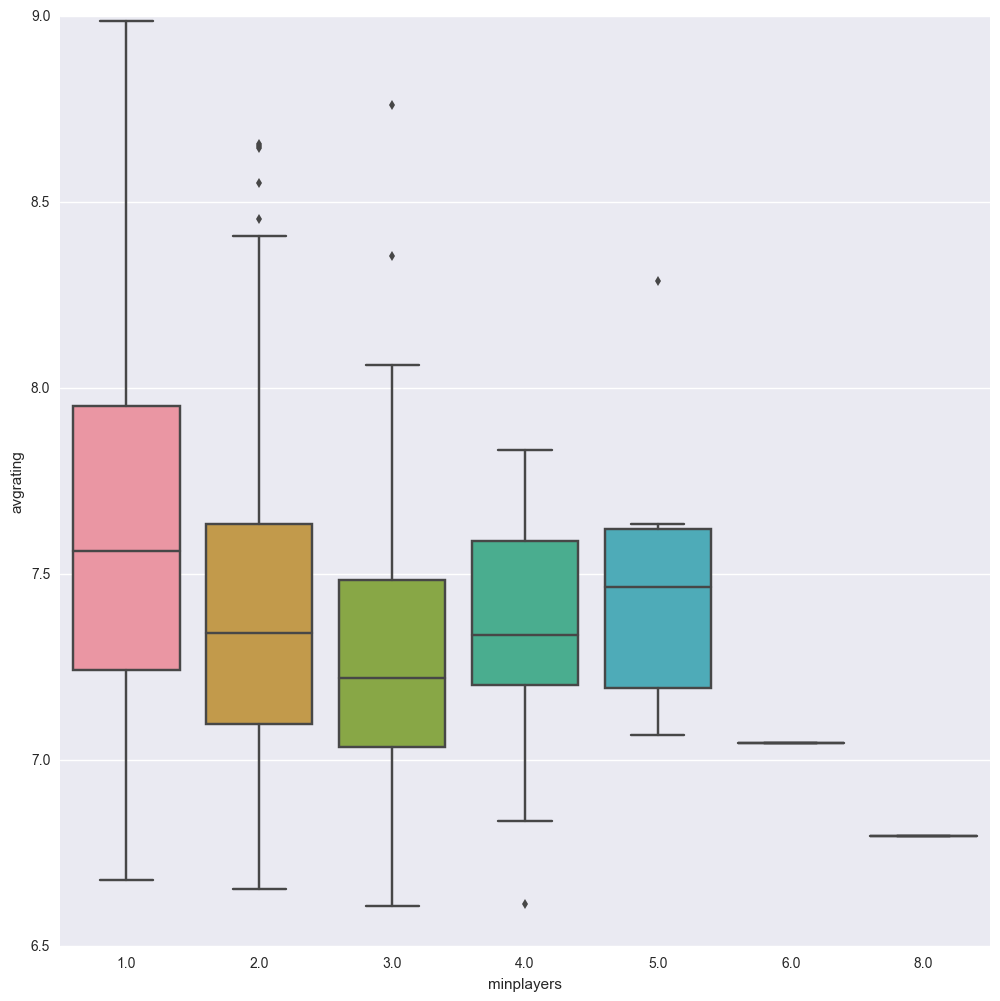

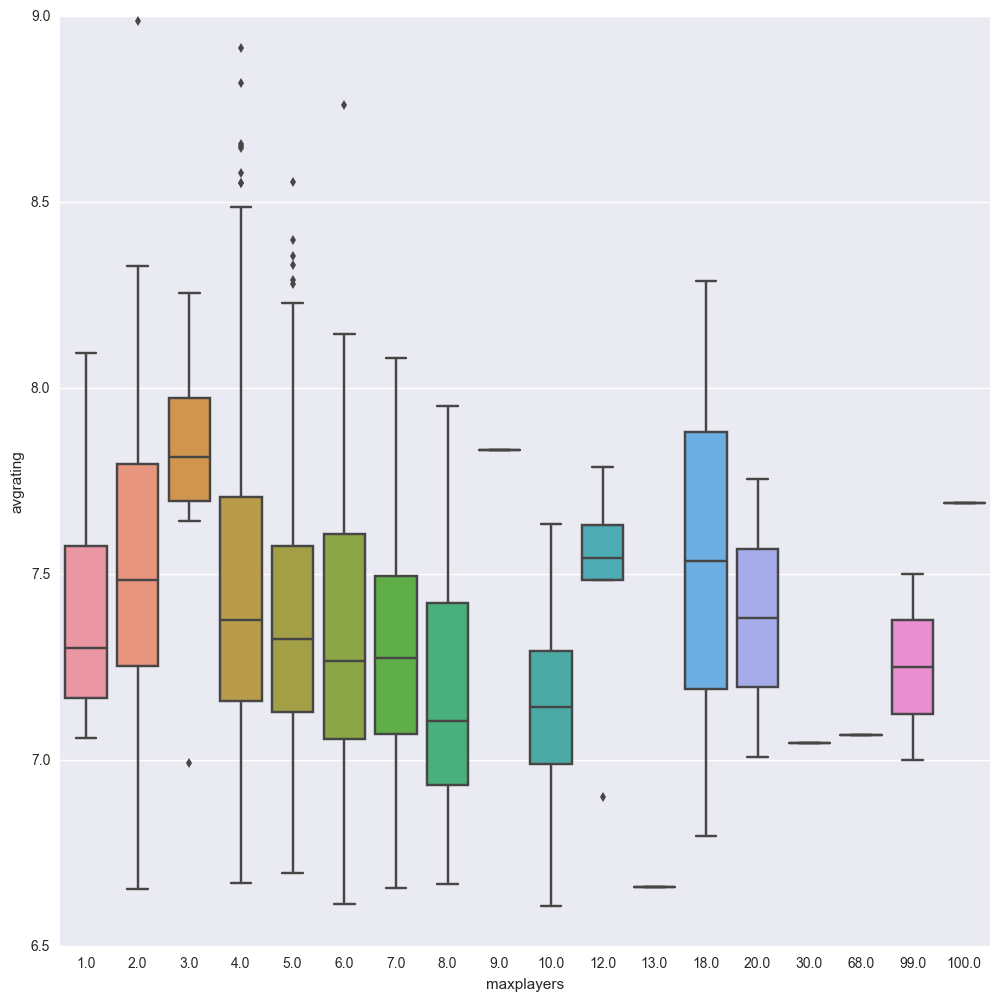

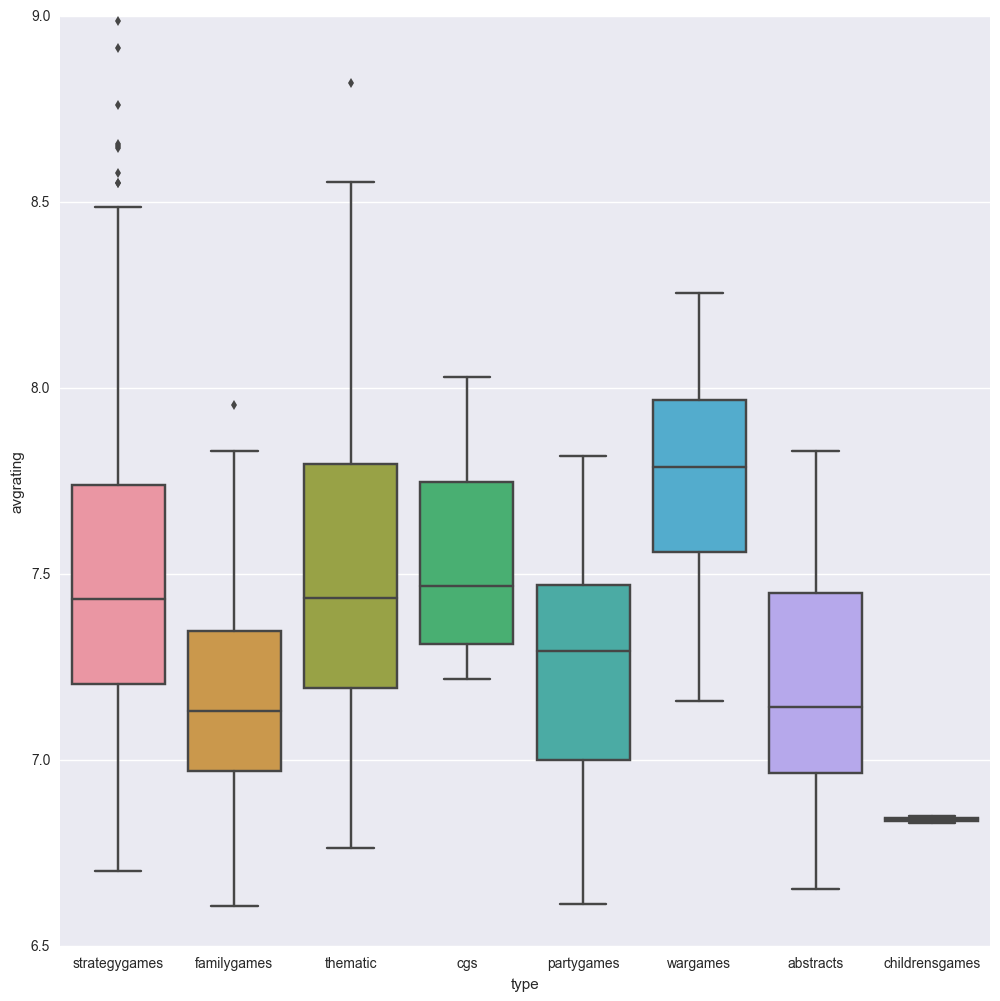

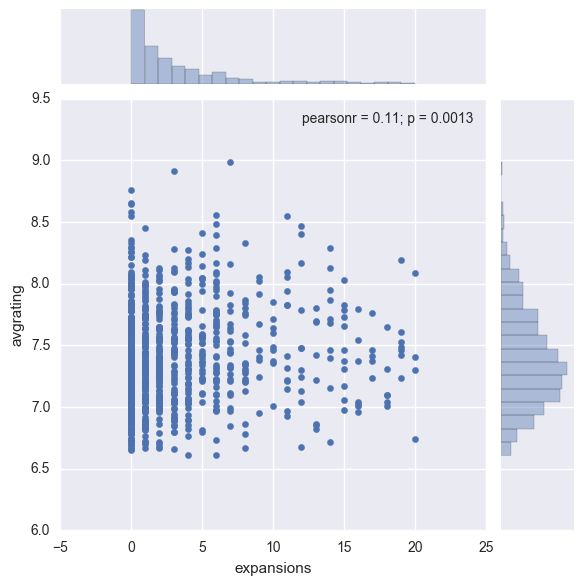

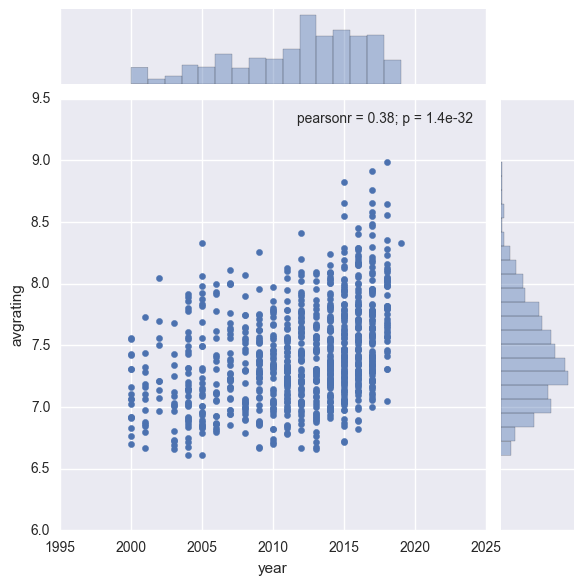

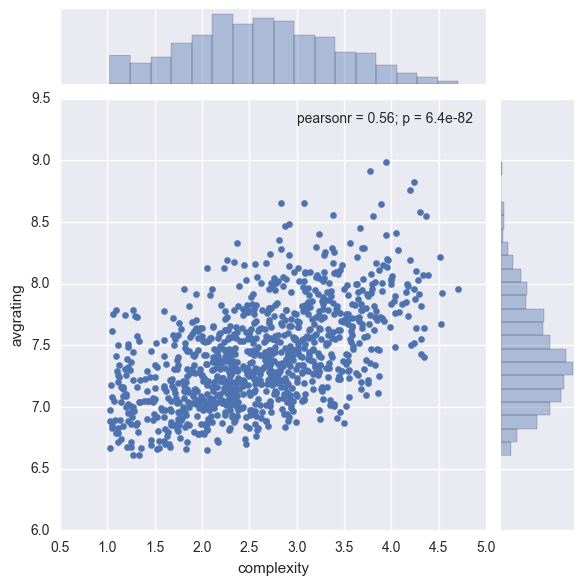

In [6]:
plt.figure(1,figsize=(12,12))
sns.boxplot(x='minplayers',y='avgrating',data=data)
plt.show()
plt.figure(1,figsize=(12,12))
sns.boxplot(x='maxplayers',y='avgrating',data=data)
plt.show()
plt.figure(1,figsize=(12,12))
sns.boxplot(x='type',y='avgrating',data=data)
plt.show()
plt.figure(1,figsize=(12,12))
sns.jointplot(x='expansions',y='avgrating',data=data[(data['expansions']<=20)])
plt.show()
plt.figure(1,figsize=(12,12))
sns.jointplot(x='year',y='avgrating',data=data[(data['year']>=2000)],xlim=[1995,2025])
plt.show()
plt.figure(1,figsize=(12,12))
sns.jointplot(x='complexity',y='avgrating',data=data)
plt.show()

We see above that higher average ratings are associated with more complex games. Additionally, we notice that there are more games in the top 1000 from recent years. Though Pearson's correlation coefficients of PC = 0.56 and PC = 0.38 respectively indicate that this relationship exhibits a fair bit of spread. These are all interesting factoids to keep in mind as we build our recommender system. In some cases, it may be desirable to build a system which is somehow meant to counter these biases. In my case however, I wish to build a collaborative recommender system which give recommendations based on preferences of BGG users. $\textit{i.e.}$ recommendations by gamers for gamers. One hopes that the collaborative filtering method chosen will effectively captures biases of the users who share the preferences of the person for which we make a recommendation.

# Digging in at the user level

We have just looked at trends in preferences for BGG users overall relating to complexity game age, and a couple of other factors using game level statistics. Before we dive into building our recommender system, it would be interesting to note some statistics across users. For example, how many games do users rate? How is the average/median/min/max of a users ratings distributed? Relating to the latter question, perhaps there are users who only rate games highly or only rate games poorly.


In [7]:
sc.stop()

In [8]:
sc = SparkContext('local[*]','temp')
files = sc.wholeTextFiles(local_path('../DataAcquisition/Data/*/*.xml'))

In [9]:
rating_counts = files.flatMap(user_rating_counter).reduceByKey(lambda x,y: x+y).collect()
rating_pairs = files.flatMap(user_rating_pairs)
rating_min = rating_pairs.reduceByKey(lambda x,y: min(x,y)).collect()
rating_all = rating_pairs.collect()
rating_max = rating_pairs.reduceByKey(lambda x,y: max(x,y)).collect()

In [10]:
def hist_plots(my_array,x_lab,y_lab,y_scale,title,bins=10,restricted=False,conditional_array=None):
    
    #This function will plot array histograms. The inputs are
    # an array, plot x and y labels, the y_scale, a title, and whether the array should be
    # restricted to having more than one comment
    
    if restricted:
        
        final = np.array([x[0] for x in zip(my_array,conditional_array) if x[1]>1])
        
    else:
        
        final = my_array
    
    final = np.array(final)
    
    print('average',title,np.mean(final))
    print('2.5 percentile of',title,np.quantile(final,0.025))
    print('median of',title,np.quantile(final,0.5))
    print('97.5 percentile of',title,np.quantile(final,0.975))
    plt.hist(final,bins=bins)
    plt.yscale(y_scale)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()
    
    

average rating counts 30.740197058517744
2.5 percentile of rating counts 1.0
median of rating counts 11.0
97.5 percentile of rating counts 188.0


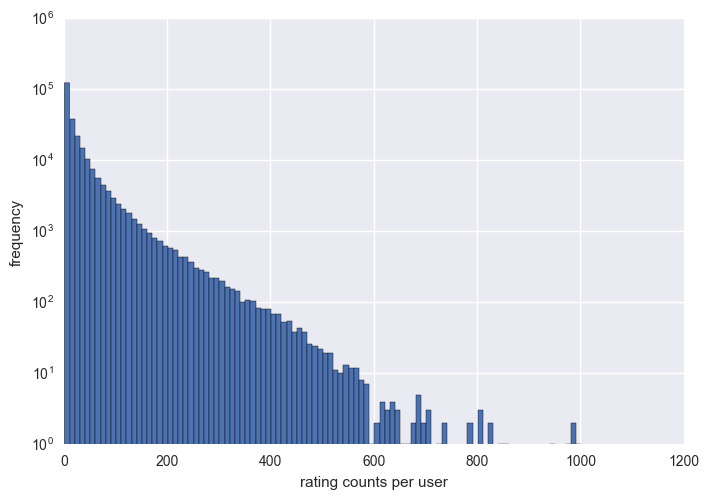

average min rating 6.169944116835547
2.5 percentile of min rating 1.0
median of min rating 6.0
97.5 percentile of min rating 10.0


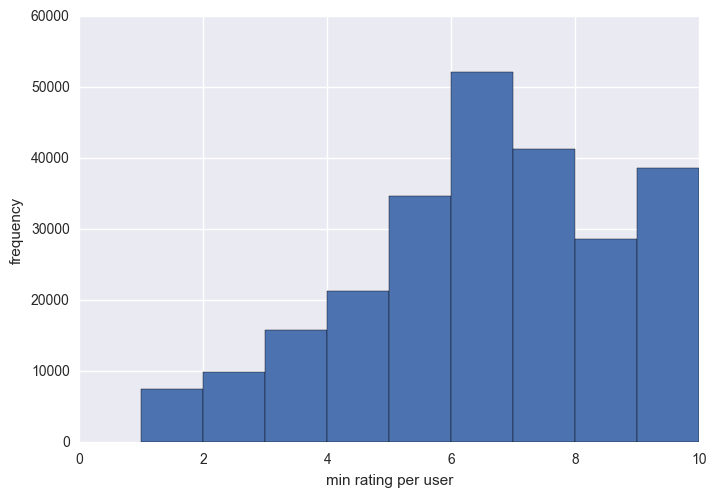

average restricted min rating 5.672845186040337
2.5 percentile of restricted min rating 1.0
median of restricted min rating 6.0
97.5 percentile of restricted min rating 9.0


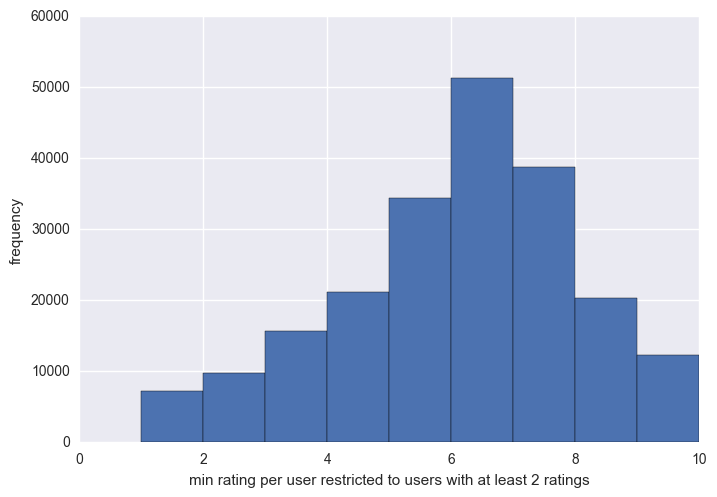

average max rating 9.416640238525579
2.5 percentile of max rating 7.5
median of max rating 10.0
97.5 percentile of max rating 10.0


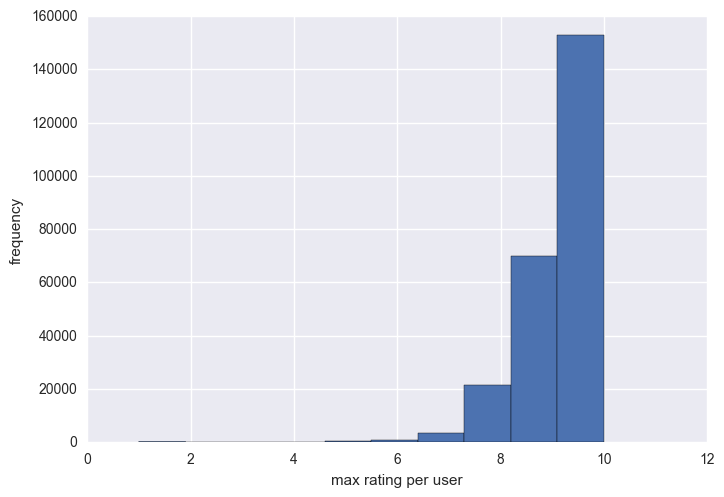

average restricted max rating 9.522264747394772
2.5 percentile of restricted max rating 8.0
median of restricted max rating 10.0
97.5 percentile of restricted max rating 10.0


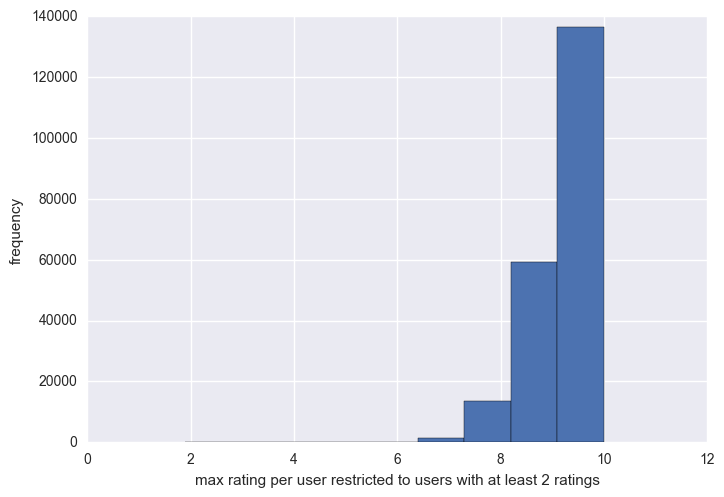

average sum of min and max rating per user 15.586584355361127
2.5 percentile of sum of min and max rating per user 11.0
median of sum of min and max rating per user 16.0
97.5 percentile of sum of min and max rating per user 20.0


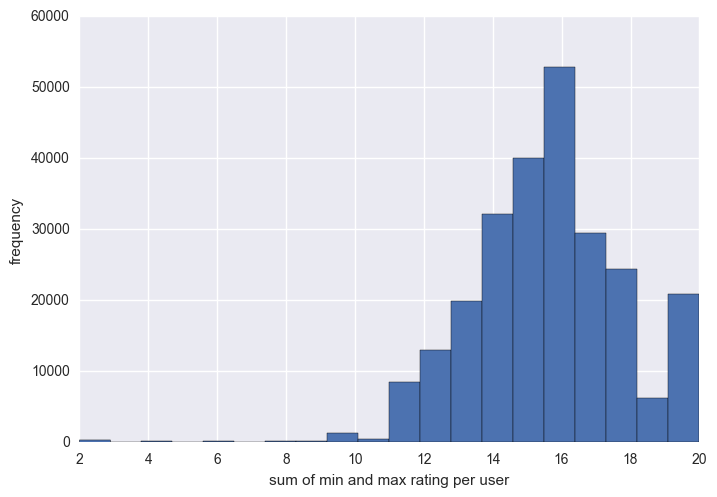

average sum of min and max rating per user restricted to users with at least 2 ratings 15.19510993343511
2.5 percentile of sum of min and max rating per user restricted to users with at least 2 ratings 11.0
median of sum of min and max rating per user restricted to users with at least 2 ratings 15.0
97.5 percentile of sum of min and max rating per user restricted to users with at least 2 ratings 19.0


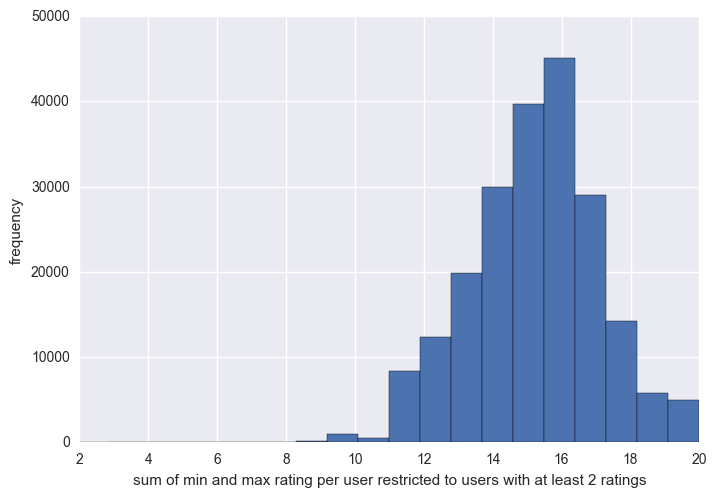

average overall rating per comment 7.449598272742576
2.5 percentile of overall rating per comment 4.0
median of overall rating per comment 7.5
97.5 percentile of overall rating per comment 10.0


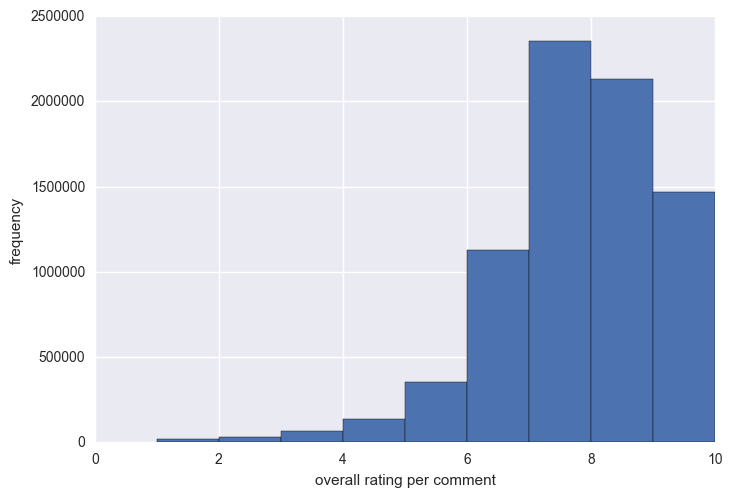

In [11]:
counts = [x[1] for x in rating_counts]
min_ratings = [x[1] for x in rating_min]
overall_ratings = [x[1] for x in rating_all]
max_ratings = [x[1] for x in rating_max]
sum_min_max = [x[0]+x[1] for x in zip(min_ratings,max_ratings)]

hist_plots(counts,'rating counts per user','frequency','log','rating counts',bins=100)
hist_plots(min_ratings,'min rating per user','frequency','linear','min rating')
hist_plots(min_ratings,'min rating per user restricted to users with at least 2 ratings','frequency','linear',
           'restricted min rating',bins=10, restricted = True,conditional_array = counts)
hist_plots(max_ratings,'max rating per user','frequency','linear','max rating',bins=10)
hist_plots(max_ratings,'max rating per user restricted to users with at least 2 ratings','frequency','linear',
           'restricted max rating',bins=10, restricted = True,conditional_array = counts)
hist_plots(sum_min_max,'sum of min and max rating per user','frequency','linear',
           'sum of min and max rating per user',bins=20)
hist_plots(sum_min_max,'sum of min and max rating per user restricted to users with at least 2 ratings','frequency','linear',
           'sum of min and max rating per user restricted to users with at least 2 ratings',
          bins=20, restricted = True,conditional_array = counts)
hist_plots(overall_ratings,'overall rating per comment','frequency','linear','overall rating per comment',bins=10)

We notice a few things from this. In terms of counts, we see that a typical user rates on the order of $\sim10$ games ($50^{th}$ percentile) with the average count being $\sim30$ games (the distribution has a large peak at low numbers, but a reasonably long tail. For example about $10^5$ users only rate 1 game, but a good upper limit for normal activity is around $\sim200$ game ratings ($97.5^{th}$ percentile). Note that somewhere around $17\%$ of users rate only one game. We will remove these users as well as users who rate more than 200 games when building our recommender systems. Let's visualize how the count changes with the quantile and then return to discussion of the above plots.

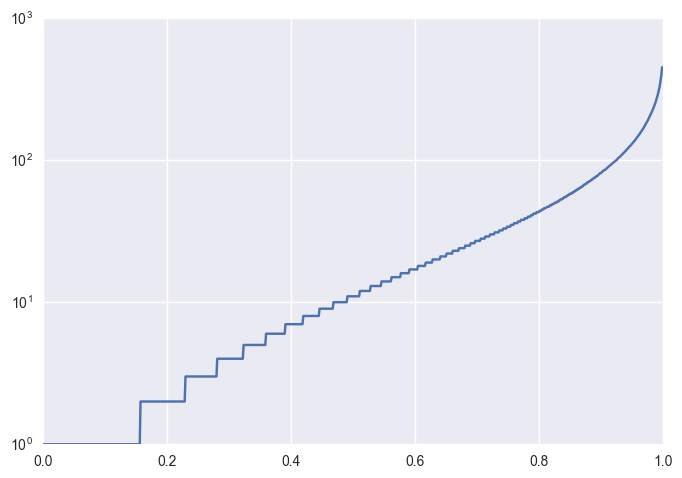

In [12]:
x = np.arange(0,1,0.00125)
quants=np.quantile(counts,x)
plt.plot(x,quants)
plt.yscale('log')
plt.show()

So if we remove users with $< 2$ ratings and $>200$ ratings, we will capture about $80\%$ or so of users. In regards to rating distributions, we saw from the unrestricted and restricted min and max ratings that the max ratings had more high ratings (9 or 10) before the restriction, so it seems that people are rating their first games highly on BGG. We also see that the sum of min and max ratings is centered around 16 and if we remove users with only one rating we unsurprisingly significantly drop the count of min$+$max $= 20$. Finally, we see that the overall ratings skew high (2.5$^{th}$ percentile  = 4.0) this isn't too surprising since we are after all looking at the top 1000 games by BGG rating. To finish the exploratory analysis, let's look at the total count of users and ratings in this dataset. This will then tell us how sparse the ratings matrix is.

In [13]:
users = defaultdict(int)
user_count = 0
for x in rating_all:
    
    if users[x[0]] == 0:
        
        users[x[0]] = 1
        
        user_count+=1
        
print('number of ratings is',len(overall_ratings))
print('number of users is',user_count)
print('sparsity of ratings matrix is', 100*(1-len(overall_ratings)/(user_count*1000)),'%')

number of ratings is 7687447
number of users is 250078
sparsity of ratings matrix is 96.92598029414823 %
